# Method 7 - Best Ideas High Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[best_ideas['herf_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

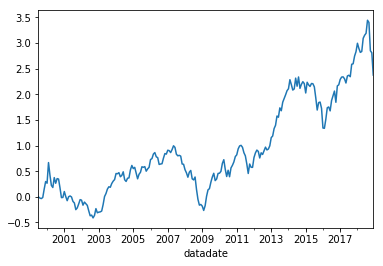

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.297574
2000-12-31   -0.238597
2001-12-31   -0.043593
2002-12-31   -0.271216
2003-12-31    0.941266
2004-12-31    0.205909
2005-12-31   -0.022227
2006-12-31    0.163370
2007-12-31   -0.108516
2008-12-31   -0.479528
2009-12-31    0.711196
2010-12-31    0.225947
2011-12-31   -0.117735
2012-12-31    0.266776
2013-12-31    0.539397
2014-12-31    0.045224
2015-12-31   -0.150164
2016-12-31    0.167874
2017-12-31    0.203246
2018-12-31   -0.119309
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     457.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          6.86e-108
Time:                        22:18:49   Log-Likelihood:                 538.73
No. Observations:                 234   AIC:                            -1067.
Df Residuals:                     229   BIC:                            -1050.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      2.208      0.028       0.000       0.007
mktrf          0.9447      0.046     20.702      0.000       0.855       1.035
me             0.7518      0.053     14.163      0.000       0.647       0.856
ia            -0.0702      0.081     -0.870      0.385      -0.229       0.089
roe           -0.6708      0.069     -9.714      0.000      -0.807      -0.535
==============================================================================
Omnibus:                       10.138   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               16.411
Skew:                           0.233   Prob(JB):                     0.000273
Kurtosis:                       4.211   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     218.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.78e-77
Time:                        22:18:49   Log-Likelihood:                 538.73
No. Observations:                 234   AIC:                            -1067.
Df Residuals:                     229   BIC:                            -1050.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      1.875      0.061      -0.000       0.008
mktrf          0.9447      0.057     16.716      0.000       0.834       1.056
me             0.7518      0.109      6.917      0.000       0.539       0.965
ia            -0.0702      0.124     -0.566      0.571      -0.313       0.173
roe           -0.6708      0.107     -6.291      0.000      -0.880      -0.462
==============================================================================
Omnibus:                       10.138   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               16.411
Skew:                           0.233   Prob(JB):                     0.000273
Kurtosis:                       4.211   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     225.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.94e-78
Time:                        22:18:49   Log-Likelihood:                 538.73
No. Observations:                 234   AIC:                            -1067.
Df Residuals:                     229   BIC:                            -1050.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.002      1.849      0.064      -0.000       0.008
mktrf          0.9447      0.054     17.511      0.000       0.839       1.050
me             0.7518      0.114      6.599      0.000       0.529       0.975
ia            -0.0702      0.112     -0.629      0.530      -0.289       0.149
roe           -0.6708      0.099     -6.788      0.000      -0.865      -0.477
==============================================================================
Omnibus:                       10.138   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               16.411
Skew:                           0.233   Prob(JB):                     0.000273
Kurtosis:                       4.211   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     380.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.64e-108
Time:                        22:18:49   Log-Likelihood:                 543.41
No. Observations:                 234   AIC:                            -1075.
Df Residuals:                     228   BIC:                            -1054.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.844      0.066      -0.000       0.006
mktrf          1.0445      0.045     23.253      0.000       0.956       1.133
smb            0.7443      0.059     12.559      0.000       0.628       0.861
hml           -0.1085      0.070     -1.552      0.122      -0.246       0.029
rmw           -0.6277      0.079     -7.945      0.000      -0.783      -0.472
cma            0.2529      0.100      2.518      0.012       0.055       0.451
==============================================================================
Omnibus:                       10.621   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               13.672
Skew:                           0.347   Prob(JB):                      0.00107
Kurtosis:                       3.960   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     357.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.06e-105
Time:                        22:18:49   Log-Likelihood:                 543.41
No. Observations:                 234   AIC:                            -1075.
Df Residuals:                     228   BIC:                            -1054.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.652      0.099      -0.001       0.007
mktrf          1.0445      0.038     27.243      0.000       0.969       1.120
smb            0.7443      0.073     10.262      0.000       0.602       0.886
hml           -0.1085      0.106     -1.025      0.305      -0.316       0.099
rmw           -0.6277      0.096     -6.571      0.000      -0.815      -0.440
cma            0.2529      0.120      2.104      0.035       0.017       0.489
==============================================================================
Omnibus:                       10.621   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               13.672
Skew:                           0.347   Prob(JB):                      0.00107
Kurtosis:                       3.960   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     467.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.24e-117
Time:                        22:18:49   Log-Likelihood:                 543.41
No. Observations:                 234   AIC:                            -1075.
Df Residuals:                     228   BIC:                            -1054.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.002      1.599      0.110      -0.001       0.007
mktrf          1.0445      0.040     26.185      0.000       0.966       1.123
smb            0.7443      0.083      9.004      0.000       0.582       0.906
hml           -0.1085      0.088     -1.240      0.215      -0.280       0.063
rmw           -0.6277      0.104     -6.057      0.000      -0.831      -0.425
cma            0.2529      0.089      2.845      0.004       0.079       0.427
==============================================================================
Omnibus:                       10.621   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               13.672
Skew:                           0.347   Prob(JB):                      0.00107
Kurtosis:                       3.960   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     380.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.54e-100
Time:                        22:18:49   Log-Likelihood:                 519.79
No. Observations:                 234   AIC:                            -1030.
Df Residuals:                     229   BIC:                            -1012.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.696      0.487      -0.002       0.005
mktrf          1.1098      0.046     24.360      0.000       1.020       1.200
smb            0.9936      0.057     17.471      0.000       0.882       1.106
hml           -0.0618      0.056     -1.094      0.275      -0.173       0.050
umd           -0.1431      0.037     -3.861      0.000      -0.216      -0.070
==============================================================================
Omnibus:                       16.194   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.597
Skew:                           0.366   Prob(JB):                     3.74e-07
Kurtosis:                       4.581   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     321.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.91e-93
Time:                        22:18:50   Log-Likelihood:                 519.79
No. Observations:                 234   AIC:                            -1030.
Df Residuals:                     229   BIC:                            -1012.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.639      0.523      -0.003       0.005
mktrf          1.1098      0.041     27.012      0.000       1.029       1.190
smb            0.9936      0.110      9.006      0.000       0.777       1.210
hml           -0.0618      0.095     -0.650      0.516      -0.248       0.125
umd           -0.1431      0.072     -1.983      0.047      -0.285      -0.002
==============================================================================
Omnibus:                       16.194   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.597
Skew:                           0.366   Prob(JB):                     3.74e-07
Kurtosis:                       4.581   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     362.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.63e-98
Time:                        22:18:50   Log-Likelihood:                 519.79
No. Observations:                 234   AIC:                            -1030.
Df Residuals:                     229   BIC:                            -1012.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.649      0.517      -0.002       0.005
mktrf          1.1098      0.039     28.394      0.000       1.033       1.186
smb            0.9936      0.111      8.981      0.000       0.777       1.210
hml           -0.0618      0.090     -0.685      0.493      -0.239       0.115
umd           -0.1431      0.076     -1.875      0.061      -0.293       0.007
==============================================================================
Omnibus:                       16.194   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.597
Skew:                           0.366   Prob(JB):                     3.74e-07
Kurtosis:                       4.581   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     204.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.91e-51
Time:                        22:18:50   Log-Likelihood:                 250.87
No. Observations:                 120   AIC:                            -491.7
Df Residuals:                     115   BIC:                            -477.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.003      1.795      0.075      -0.001       0.011
mktrf          0.8862      0.079     11.252      0.000       0.730       1.042
me             0.7517      0.078      9.664      0.000       0.598       0.906
ia            -0.0992      0.122     -0.814      0.417      -0.340       0.142
roe           -0.7161      0.108     -6.642      0.000      -0.930      -0.503
==============================================================================
Omnibus:                        0.506   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.777   Jarque-Bera (JB):                0.186
Skew:                           0.046   Prob(JB):                        0.911
Kurtosis:                       3.170   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     118.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.19e-40
Time:                        22:18:50   Log-Likelihood:                 250.87
No. Observations:                 120   AIC:                            -491.7
Df Residuals:                     115   BIC:                            -477.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.003      1.526      0.127      -0.001       0.012
mktrf          0.8862      0.085     10.386      0.000       0.719       1.053
me             0.7517      0.143      5.255      0.000       0.471       1.032
ia            -0.0992      0.177     -0.559      0.576      -0.447       0.248
roe           -0.7161      0.157     -4.560      0.000      -1.024      -0.408
==============================================================================
Omnibus:                        0.506   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.777   Jarque-Bera (JB):                0.186
Skew:                           0.046   Prob(JB):                        0.911
Kurtosis:                       3.170   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     132.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.37e-42
Time:                        22:18:50   Log-Likelihood:                 250.87
No. Observations:                 120   AIC:                            -491.7
Df Residuals:                     115   BIC:                            -477.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.004      1.493      0.135      -0.002       0.012
mktrf          0.8862      0.077     11.531      0.000       0.736       1.037
me             0.7517      0.152      4.951      0.000       0.454       1.049
ia            -0.0992      0.161     -0.615      0.538      -0.415       0.217
roe           -0.7161      0.147     -4.867      0.000      -1.005      -0.428
==============================================================================
Omnibus:                        0.506   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.777   Jarque-Bera (JB):                0.186
Skew:                           0.046   Prob(JB):                        0.911
Kurtosis:                       3.170   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     181.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.43e-52
Time:                        22:18:50   Log-Likelihood:                 256.93
No. Observations:                 120   AIC:                            -501.9
Df Residuals:                     114   BIC:                            -485.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.003      2.173      0.032       0.001       0.012
mktrf          1.0480      0.079     13.215      0.000       0.891       1.205
smb            0.7419      0.090      8.260      0.000       0.564       0.920
hml           -0.1389      0.110     -1.262      0.210      -0.357       0.079
rmw           -0.6313      0.130     -4.864      0.000      -0.888      -0.374
cma            0.3024      0.142      2.127      0.036       0.021       0.584
==============================================================================
Omnibus:                        0.978   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.613   Jarque-Bera (JB):                0.638
Skew:                           0.163   Prob(JB):                        0.727
Kurtosis:                       3.146   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     246.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.44e-59
Time:                        22:18:50   Log-Likelihood:                 256.93
No. Observations:                 120   AIC:                            -501.9
Df Residuals:                     114   BIC:                            -485.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.003      1.984      0.047    7.52e-05       0.012
mktrf          1.0480      0.079     13.318      0.000       0.894       1.202
smb            0.7419      0.110      6.728      0.000       0.526       0.958
hml           -0.1389      0.162     -0.857      0.391      -0.457       0.179
rmw           -0.6313      0.168     -3.748      0.000      -0.961      -0.301
cma            0.3024      0.147      2.059      0.039       0.015       0.590
==============================================================================
Omnibus:                        0.978   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.613   Jarque-Bera (JB):                0.638
Skew:                           0.163   Prob(JB):                        0.727
Kurtosis:                       3.146   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     396.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.65e-70
Time:                        22:18:50   Log-Likelihood:                 256.93
No. Observations:                 120   AIC:                            -501.9
Df Residuals:                     114   BIC:                            -485.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.003      1.916      0.055      -0.000       0.013
mktrf          1.0480      0.083     12.642      0.000       0.885       1.210
smb            0.7419      0.128      5.785      0.000       0.491       0.993
hml           -0.1389      0.152     -0.915      0.360      -0.436       0.159
rmw           -0.6313      0.193     -3.270      0.001      -1.010      -0.253
cma            0.3024      0.100      3.021      0.003       0.106       0.499
==============================================================================
Omnibus:                        0.978   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.613   Jarque-Bera (JB):                0.638
Skew:                           0.163   Prob(JB):                        0.727
Kurtosis:                       3.146   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     182.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.46e-49
Time:                        22:18:50   Log-Likelihood:                 244.93
No. Observations:                 120   AIC:                            -479.9
Df Residuals:                     115   BIC:                            -465.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.003      1.220      0.225      -0.002       0.010
mktrf          1.1276      0.073     15.468      0.000       0.983       1.272
smb            1.0180      0.083     12.265      0.000       0.854       1.182
hml           -0.0943      0.083     -1.135      0.259      -0.259       0.070
umd           -0.1347      0.051     -2.628      0.010      -0.236      -0.033
==============================================================================
Omnibus:                        3.260   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.196   Jarque-Bera (JB):                3.030
Skew:                           0.190   Prob(JB):                        0.220
Kurtosis:                       3.680   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     172.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.15e-47
Time:                        22:18:50   Log-Likelihood:                 244.93
No. Observations:                 120   AIC:                            -479.9
Df Residuals:                     115   BIC:                            -465.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.003      1.173      0.241      -0.002       0.010
mktrf          1.1276      0.061     18.341      0.000       1.007       1.248
smb            1.0180      0.129      7.873      0.000       0.765       1.271
hml           -0.0943      0.126     -0.750      0.453      -0.341       0.152
umd           -0.1347      0.081     -1.664      0.096      -0.293       0.024
==============================================================================
Omnibus:                        3.260   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.196   Jarque-Bera (JB):                3.030
Skew:                           0.190   Prob(JB):                        0.220
Kurtosis:                       3.680   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.859
Method:                 Least Squares   F-statistic:                     220.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.62e-53
Time:                        22:18:50   Log-Likelihood:                 244.93
No. Observations:                 120   AIC:                            -479.9
Df Residuals:                     115   BIC:                            -465.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.003      1.201      0.230      -0.002       0.010
mktrf          1.1276      0.061     18.574      0.000       1.009       1.247
smb            1.0180      0.131      7.763      0.000       0.761       1.275
hml           -0.0943      0.126     -0.750      0.453      -0.341       0.152
umd           -0.1347      0.083     -1.628      0.104      -0.297       0.027
==============================================================================
Omnibus:                        3.260   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.196   Jarque-Bera (JB):                3.030
Skew:                           0.190   Prob(JB):                        0.220
Kurtosis:                       3.680   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     327.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.96e-60
Time:                        22:18:50   Log-Likelihood:                 312.72
No. Observations:                 114   AIC:                            -615.4
Df Residuals:                     109   BIC:                            -601.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.826      0.411      -0.002       0.004
mktrf          1.0397      0.047     22.203      0.000       0.947       1.133
me             0.6704      0.072      9.272      0.000       0.527       0.814
ia            -0.0380      0.100     -0.378      0.706      -0.237       0.161
roe           -0.6449      0.088     -7.318      0.000      -0.820      -0.470
==============================================================================
Omnibus:                        0.460   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.795   Jarque-Bera (JB):                0.615
Skew:                          -0.102   Prob(JB):                        0.735
Kurtosis:                       2.704   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     711.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.25e-77
Time:                        22:18:50   Log-Likelihood:                 312.72
No. Observations:                 114   AIC:                            -615.4
Df Residuals:                     109   BIC:                            -601.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.862      0.389      -0.002       0.004
mktrf          1.0397      0.047     22.026      0.000       0.947       1.132
me             0.6704      0.057     11.846      0.000       0.559       0.781
ia            -0.0380      0.077     -0.496      0.620      -0.188       0.112
roe           -0.6449      0.106     -6.099      0.000      -0.852      -0.438
==============================================================================
Omnibus:                        0.460   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.795   Jarque-Bera (JB):                0.615
Skew:                          -0.102   Prob(JB):                        0.735
Kurtosis:                       2.704   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     1259.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.25e-90
Time:                        22:18:50   Log-Likelihood:                 312.72
No. Observations:                 114   AIC:                            -615.4
Df Residuals:                     109   BIC:                            -601.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.002      0.771      0.441      -0.002       0.005
mktrf          1.0397      0.036     28.497      0.000       0.968       1.111
me             0.6704      0.057     11.839      0.000       0.559       0.781
ia            -0.0380      0.073     -0.522      0.602      -0.180       0.105
roe           -0.6449      0.084     -7.699      0.000      -0.809      -0.481
==============================================================================
Omnibus:                        0.460   Durbin-Watson:                   2.159
Prob(Omnibus):                  0.795   Jarque-Bera (JB):                0.615
Skew:                          -0.102   Prob(JB):                        0.735
Kurtosis:                       2.704   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     230.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.59e-56
Time:                        22:18:50   Log-Likelihood:                 306.54
No. Observations:                 114   AIC:                            -601.1
Df Residuals:                     108   BIC:                            -584.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.336      0.737      -0.004       0.003
mktrf          1.0922      0.047     23.059      0.000       0.998       1.186
smb            0.6644      0.077      8.640      0.000       0.512       0.817
hml           -0.0033      0.098     -0.033      0.974      -0.198       0.191
rmw           -0.6313      0.120     -5.257      0.000      -0.869      -0.393
cma            0.0262      0.152      0.172      0.864      -0.276       0.328
==============================================================================
Omnibus:                        1.906   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.386   Jarque-Bera (JB):                1.498
Skew:                           0.058   Prob(JB):                        0.473
Kurtosis:                       3.550   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     295.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.81e-61
Time:                        22:18:50   Log-Likelihood:                 306.54
No. Observations:                 114   AIC:                            -601.1
Df Residuals:                     108   BIC:                            -584.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.342      0.733      -0.004       0.003
mktrf          1.0922      0.044     24.823      0.000       1.006       1.178
smb            0.6644      0.069      9.585      0.000       0.529       0.800
hml           -0.0033      0.054     -0.061      0.952      -0.108       0.102
rmw           -0.6313      0.125     -5.069      0.000      -0.875      -0.387
cma            0.0262      0.088      0.297      0.766      -0.147       0.199
==============================================================================
Omnibus:                        1.906   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.386   Jarque-Bera (JB):                1.498
Skew:                           0.058   Prob(JB):                        0.473
Kurtosis:                       3.550   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     422.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.72e-69
Time:                        22:18:50   Log-Likelihood:                 306.54
No. Observations:                 114   AIC:                            -601.1
Df Residuals:                     108   BIC:                            -584.7
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.002     -0.331      0.741      -0.004       0.003
mktrf          1.0922      0.041     26.506      0.000       1.011       1.173
smb            0.6644      0.072      9.174      0.000       0.522       0.806
hml           -0.0033      0.043     -0.075      0.940      -0.089       0.082
rmw           -0.6313      0.109     -5.794      0.000      -0.845      -0.418
cma            0.0262      0.071      0.370      0.711      -0.113       0.165
==============================================================================
Omnibus:                        1.906   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.386   Jarque-Bera (JB):                1.498
Skew:                           0.058   Prob(JB):                        0.473
Kurtosis:                       3.550   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     233.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.83e-52
Time:                        22:18:50   Log-Likelihood:                 295.19
No. Observations:                 114   AIC:                            -580.4
Df Residuals:                     109   BIC:                            -566.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.002     -0.692      0.490      -0.005       0.002
mktrf          1.1218      0.052     21.676      0.000       1.019       1.224
smb            0.8046      0.081      9.970      0.000       0.645       0.964
hml            0.0707      0.083      0.851      0.397      -0.094       0.235
umd           -0.1562      0.063     -2.492      0.014      -0.280      -0.032
==============================================================================
Omnibus:                        3.556   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                3.149
Skew:                           0.257   Prob(JB):                        0.207
Kurtosis:                       3.632   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     482.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.42e-68
Time:                        22:18:50   Log-Likelihood:                 295.19
No. Observations:                 114   AIC:                            -580.4
Df Residuals:                     109   BIC:                            -566.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.002     -0.721      0.471      -0.005       0.002
mktrf          1.1218      0.047     24.101      0.000       1.031       1.213
smb            0.8046      0.076     10.561      0.000       0.655       0.954
hml            0.0707      0.080      0.886      0.376      -0.086       0.227
umd           -0.1562      0.059     -2.631      0.009      -0.273      -0.040
==============================================================================
Omnibus:                        3.556   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                3.149
Skew:                           0.257   Prob(JB):                        0.207
Kurtosis:                       3.632   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     533.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.35e-70
Time:                        22:18:50   Log-Likelihood:                 295.19
No. Observations:                 114   AIC:                            -580.4
Df Residuals:                     109   BIC:                            -566.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.002     -0.651      0.515      -0.005       0.003
mktrf          1.1218      0.039     28.609      0.000       1.045       1.199
smb            0.8046      0.061     13.143      0.000       0.685       0.925
hml            0.0707      0.077      0.913      0.361      -0.081       0.222
umd           -0.1562      0.050     -3.137      0.002      -0.254      -0.059
==============================================================================
Omnibus:                        3.556   Durbin-Watson:                   1.912
Prob(Omnibus):                  0.169   Jarque-Bera (JB):                3.149
Skew:                           0.257   Prob(JB):                        0.207
Kurtosis:                       3.632   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""